# Analyzing Trump tweets

- Tweets were downloaded using the twint API. Documentation can be found at: 
    https://github.com/twintproject/twint

- Tweets of 2019 and 2020 were downloaded and saved in a file using the command line by running:

    ```twint -u realDonaldTrump --since 2019-01-01 -o trump.csv --csv```

## Import Libraries

In [1]:
import pandas as pd
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
import spacy

#### Extracting date, time and tweet

In [2]:
df=pd.read_excel('trump.xls')[['date','time','tweet']]
stemmer = PorterStemmer()
nlp = spacy.load('en_core_web_md') #initializing stopwords
stop_words = spacy.lang.en.stop_words.STOP_WORDS

In [3]:
def get_hashtags(text):
    hashtags = re.findall(r'\#\w+',text.lower())
    return hashtags
def get_mentions(text):
    mentions = re.findall(r'\@\w+',text.lower())
    return mentions

#### Feature Engineering

In [4]:
df['month']=df['date'].dt.month
df['year']=df['date'].dt.year
df['length']=df['tweet'].apply(lambda x: len(x.split()))
df['hashtags']=df['tweet'].apply(lambda x: get_hashtags(x))
df['mentions']=df['tweet'].apply(lambda x: get_mentions(x))
df['num_hashtags']=df['tweet'].apply(lambda x: len(get_hashtags(x)))
df['num_mentions']=df['tweet'].apply(lambda x: len(get_mentions(x)))
df['hour']=df['time'].apply(lambda x: x.hour)

#### Defining functions to clean text

In [5]:
def remove_content(text):
    text = re.sub(r"http\S+", "", text) #remove urls
    text=re.sub(r'\S+\.com\S+','',text) #remove urls
    text=re.sub(r'\@\w+','',text) #remove mentions
    text =re.sub(r'\#\w+','',text) #remove hashtags
    return text
def process_text(text, stem=False): #clean text
    text=remove_content(text)
    text = re.sub('[^A-Za-z]', ' ', text.lower()) #remove non-alphabets
    tokenized_text = word_tokenize(text) #tokenize
    clean_text = [
         word for word in tokenized_text
         if (word not in stop_words and len(word)>1)
    ]
    if stem:
        clean_text=[stemmer.stem(word) for word in clean_text]
    return ' '.join(clean_text)

In [6]:
df['cleaned_tweets']=df['tweet'].apply(lambda x: process_text(x))

In [7]:
df['tweet']=df['tweet'].apply(lambda x: remove_content(x))

In [8]:
df=df[df['length']>1].reset_index().drop(['index'],axis=1)

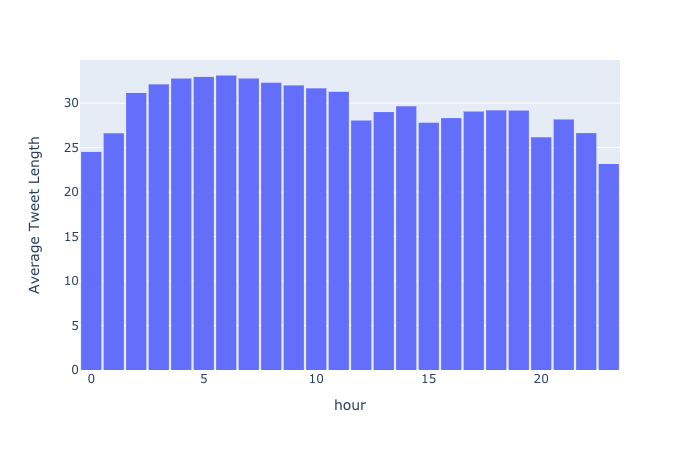

In [9]:
import plotly.express as px
fig=px.histogram(df, x='hour', y='length',histfunc='avg')
fig.update_layout(
    barmode="overlay",
    bargap=0.1,
yaxis_title='Average Tweet Length')
fig.show('png')

## Text Analysis

In [10]:
import warnings
warnings.simplefilter('ignore')

In [11]:
tweet_list = df['cleaned_tweets'].tolist()
all_words=' '.join(tweet_list).split()

In [12]:
from sklearn.feature_extraction.text import CountVectorizer
def plot_topn(sentences, ngram_range=(1,3), top=20,firstword=''):
    c=CountVectorizer(ngram_range=ngram_range)
    X=c.fit_transform(sentences)
    words=pd.DataFrame(X.sum(axis=0),columns=c.get_feature_names()).T.sort_values(0,ascending=False).reset_index()
    res=words[words['index'].apply(lambda x: firstword in x)].head(top)
    pl=px.bar(res, x='index',y=0)
    pl.update_layout(yaxis_title='count',xaxis_title='Phrases')
    pl.show('png')

### Phrases

####  Frequent unigrams

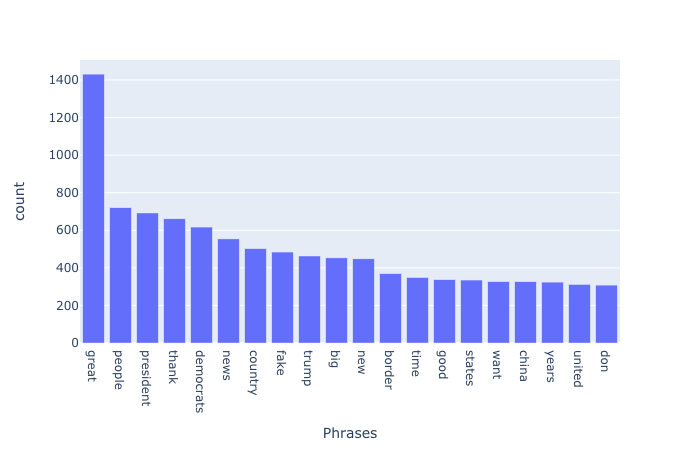

In [13]:
plot_topn(tweet_list, ngram_range=(1,1))

#### Frequent bigrams

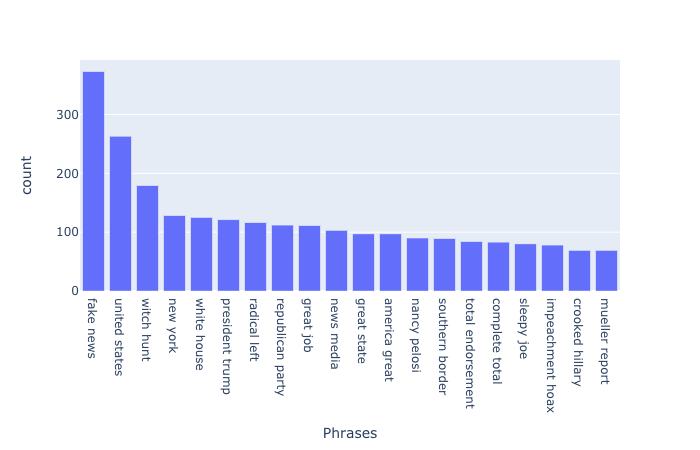

In [14]:
plot_topn(tweet_list, ngram_range=(2,2))

#### Frequent bigrams and trigrams

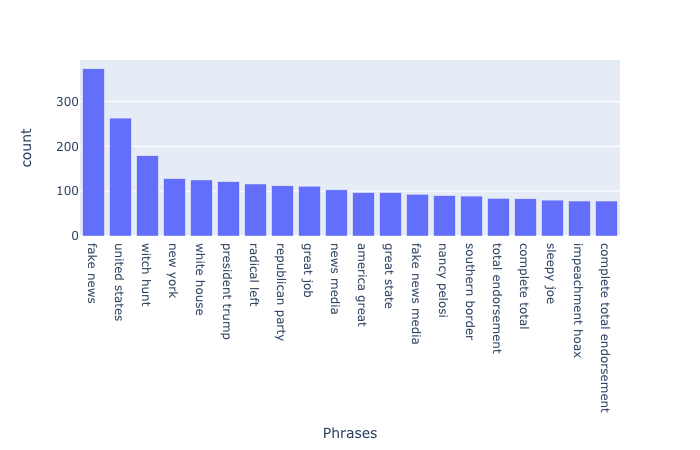

In [15]:
plot_topn(tweet_list, ngram_range=(2,3))

#### Frequent trigrams

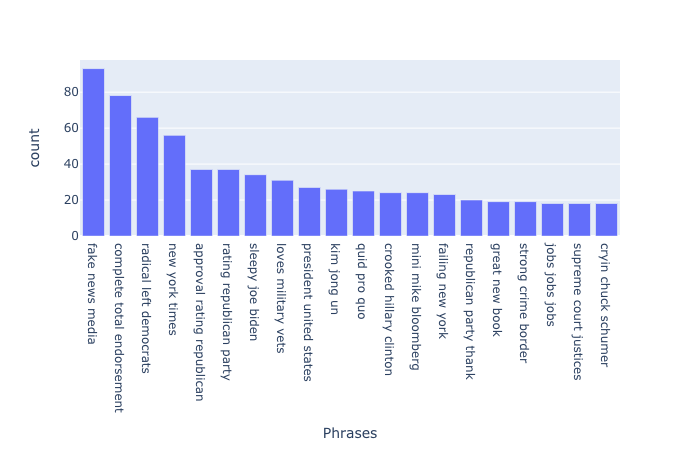

In [16]:
plot_topn(tweet_list, ngram_range=(3,3))

#### Phrases starting with 'great'

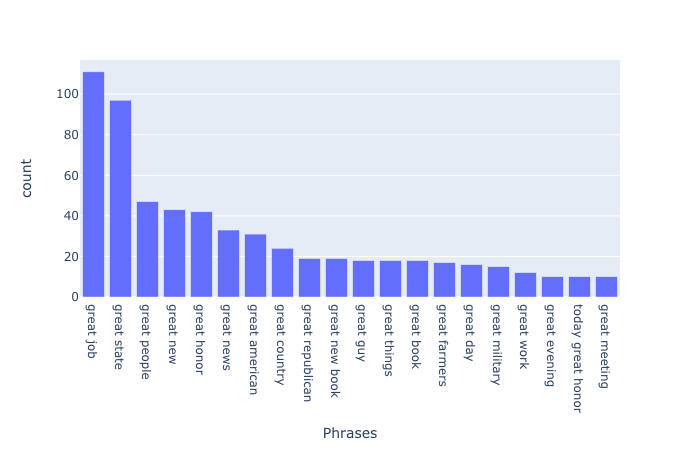

In [17]:
plot_topn(tweet_list, ngram_range=(1,3),firstword='great ')

### Mentions and Hashtags

In [18]:
hashes=df['hashtags'].tolist()
tags=[]
for x in hashes:
    if x:
        tags.extend(x)

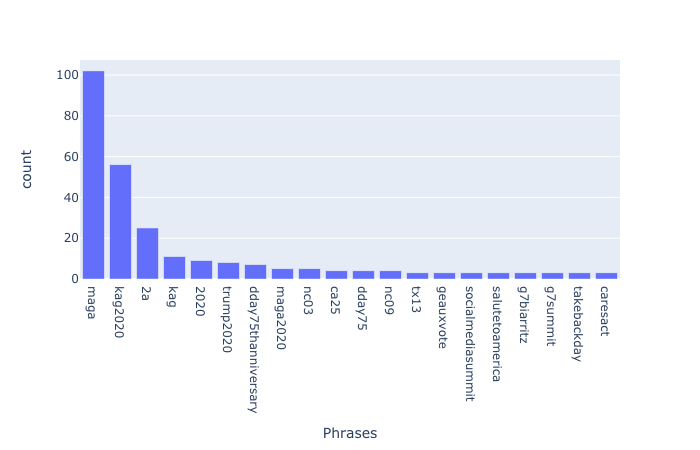

In [19]:
plot_topn(tags)

In [20]:
mentions=df['mentions'].tolist()
men=[]
for x in mentions:
    if x:
        men.extend(x)
len(men)

2049

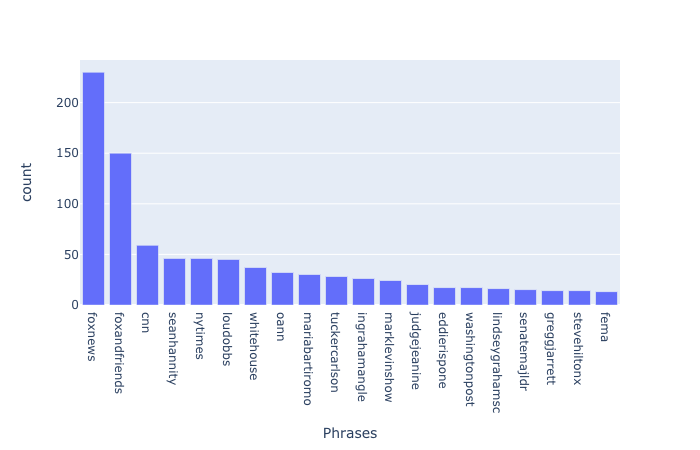

In [21]:
plot_topn(men)

## Sentiment Analysis

In [22]:
#more feature engineering
from textblob import TextBlob
df['sentiment']=df['tweet'].apply(lambda x:TextBlob(x).sentiment[0])
df['subject']=df['tweet'].apply(lambda x: TextBlob(x).sentiment[1])
df['polarity']=df['sentiment'].apply(lambda x: 'pos' if x>=0 else 'neg')
df.to_csv('trump_updated.xls',index=False)

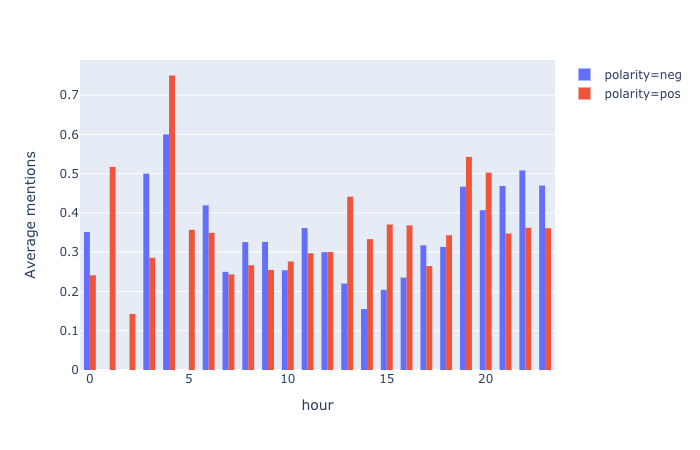

In [23]:
import plotly.express as px
fig=px.histogram(df, x='hour', y='num_mentions',color='polarity',histfunc='avg')
fig.update_layout(
    barmode="group",
    bargap=0.4,
yaxis_title='Average mentions')
fig.show('png')

In [24]:
mens=[]
for x in range(df.shape[0]):
    sentiment=df.loc[x][12]
    sub=df.loc[x][13]
    mentions=df.loc[x][7]
    polarity=df.loc[x][14]
    if mentions:
        mens.extend([(mention,1,sub,sentiment,polarity) for mention in mentions])
    else:
        mens.extend([('None',0,sub,sentiment,polarity)])
mens[:5]

[('None', 0, 0.27648809523809526, -0.07083333333333333, 'neg'),
 ('None', 0, 0.03333333333333333, -0.1, 'neg'),
 ('None', 0, 0.0, 0.0, 'pos'),
 ('None', 0, 0.0, 0.0, 'pos'),
 ('@judgejeanine', 1, 0.8, 0.78125, 'pos')]

In [25]:
ms=pd.DataFrame(mens,columns=['mention','present','subjectivity','sentiment','polarity'])

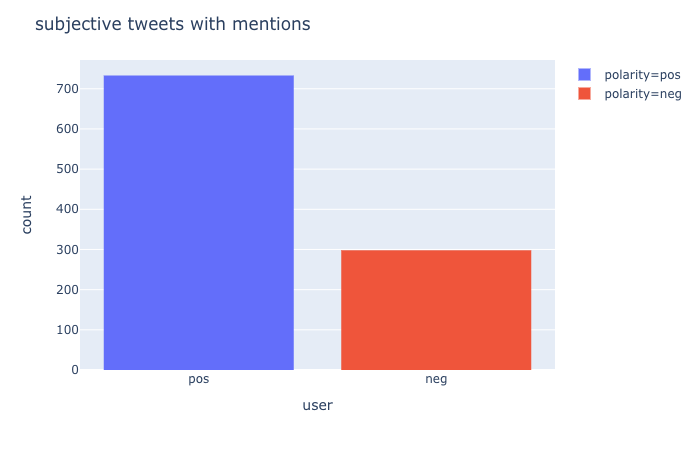

In [26]:
subjective=ms['subjectivity']>0.5
objective=ms['subjectivity']<0.5
positive=ms['sentiment']>0
negative=ms['sentiment']<0
notnone=ms['mention']!='None'
fig=px.histogram(ms[subjective & notnone],x="polarity",color='polarity').update_xaxes(categoryorder='total descending')
fig.update_layout(xaxis_title='user',title='subjective tweets with mentions')
fig.show('png')

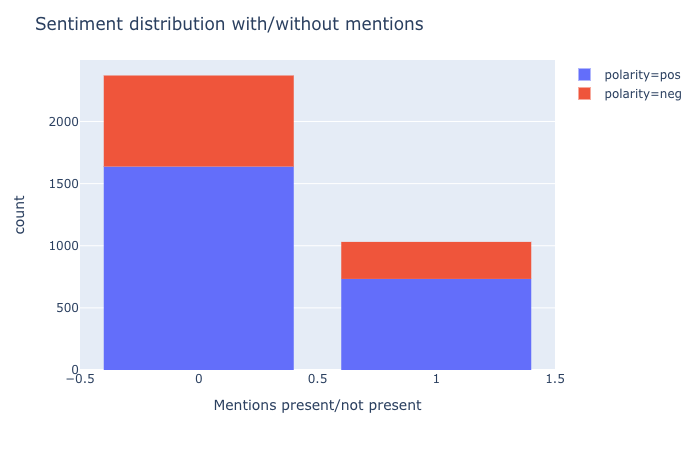

In [27]:
fig=px.histogram(ms[subjective], x='present', color='polarity')
fig.update_layout(bargap=0.2, title='Sentiment distribution with/without mentions',xaxis_title='Mentions present/not present')
fig.show('png')

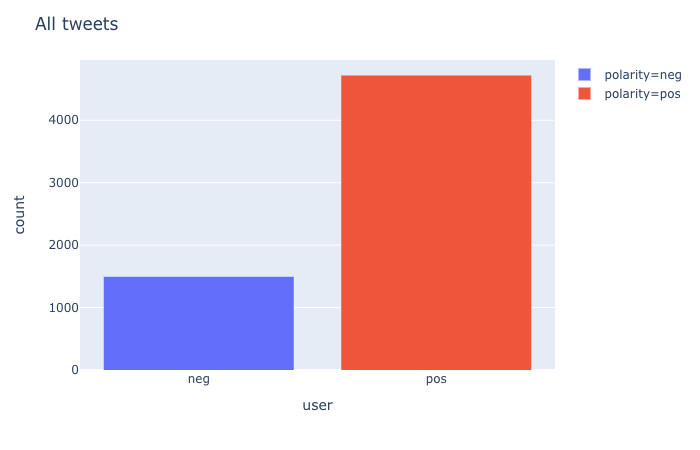

In [28]:
fig=px.histogram(df,x="polarity",color='polarity').update_xaxes(categoryorder='total ascending')
fig.update_layout(xaxis_title='user',title='All tweets')
fig.show('png')

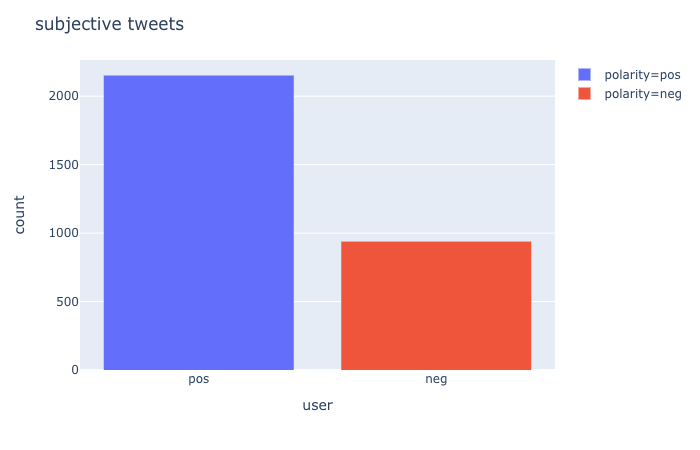

In [29]:
fig=px.histogram(df[df['subject']>0.5],x="polarity",color='polarity').update_xaxes(categoryorder='total descending')
fig.update_layout(xaxis_title='user',title='subjective tweets')
fig.show('png')

In [30]:
from wordcloud import WordCloud, STOPWORDS
temp=' '.join(df['cleaned_tweets'].tolist())
wordcloud = WordCloud(width = 800, height = 500, 
                background_color ='white',
                min_font_size = 10).generate(temp)

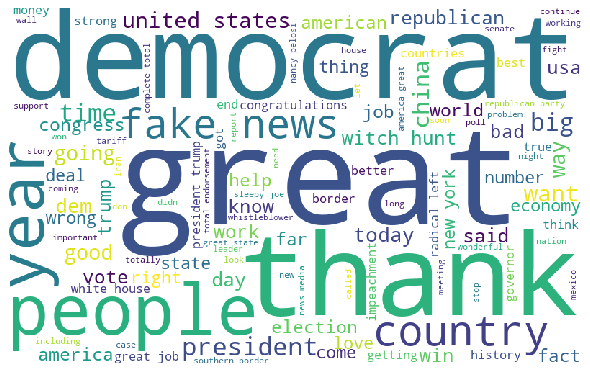

In [31]:
import matplotlib.pyplot as plt
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off")
plt.tight_layout(pad = 0) 
  
plt.show('png')

In [32]:
import plotly.graph_objects as go

mention=pd.concat([ms[subjective & notnone], pd.get_dummies(df['polarity'])],axis=1).groupby('mention').sum()[['neg','pos']]
mention['total']=mention['neg']+mention['pos']
mention=mention.sort_values('total',ascending=False)

fig=go.Figure(go.Bar(x=mention.index[:20],y=mention['pos'].tolist(),name='pos'))
fig.add_trace(go.Bar(x=mention.index[:20],y=mention['neg'].tolist(),name='neg'))
fig.update_layout(bargap=0.2,title='Sentiment distribution of top 20 mentions',
                 yaxis_title='count')

## Topic Modelling

In [33]:
from gensim import corpora
r = [process_text(x,stem=False).split() for x in df['tweet'].tolist()] 
dictionary = corpora.Dictionary(r)
corpus = [dictionary.doc2bow(rev) for rev in r]

unable to import 'smart_open.gcs', disabling that module


In [34]:
from gensim import models
model = models.ldamodel.LdaModel(corpus, num_topics=10, id2word=dictionary, passes=15)
topics = model.print_topics(num_words=8)
for topic in topics:
    print(topic[0],process_text(topic[1]))

0 thank china trade united jobs states deal tariffs
1 great total people strong vets military state bill
2 democrats great today senate republicans turkey syria house
3 great new country america big congratulations job good
4 news media house good fake white time russia
5 fake news people media new story big country
6 trump president bad people reporting obama watch credit
7 president trump best years economy history presidential election
8 border wall security democrats want southern crime country
9 mueller trump witch hunt crooked collusion president fbi


In [35]:
labels=[]
for x in model[corpus]:
    labels.append(sorted(x,key=lambda x: x[1],reverse=True)[0][0])

In [36]:
df['topics']=pd.Series(labels)

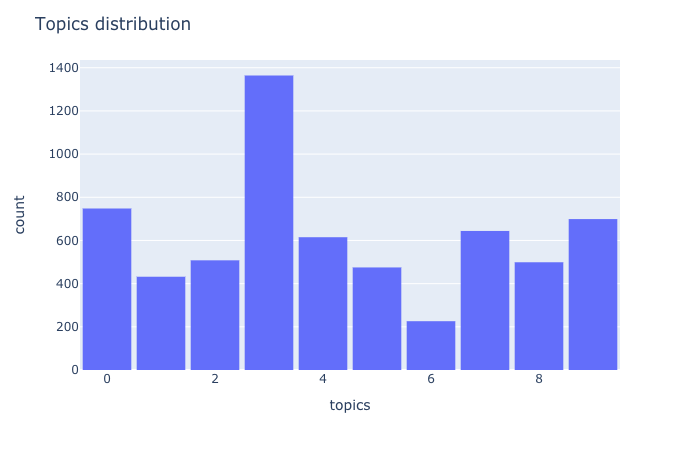

In [40]:
fig=px.histogram(df,x='topics')
fig.update_layout(title='Topics distribution', bargap=0.1)
fig.show('png')

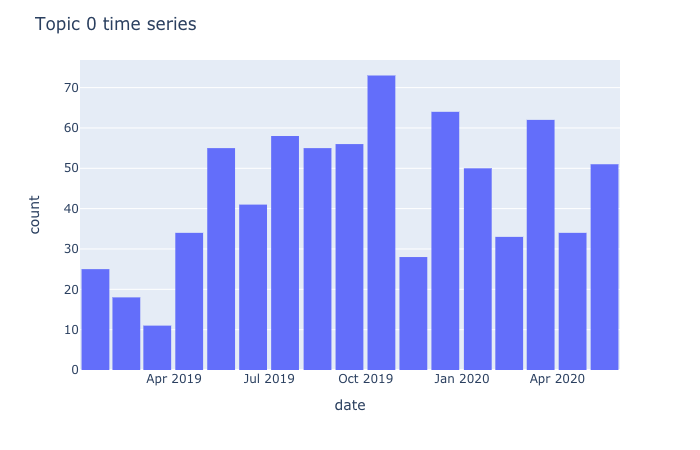

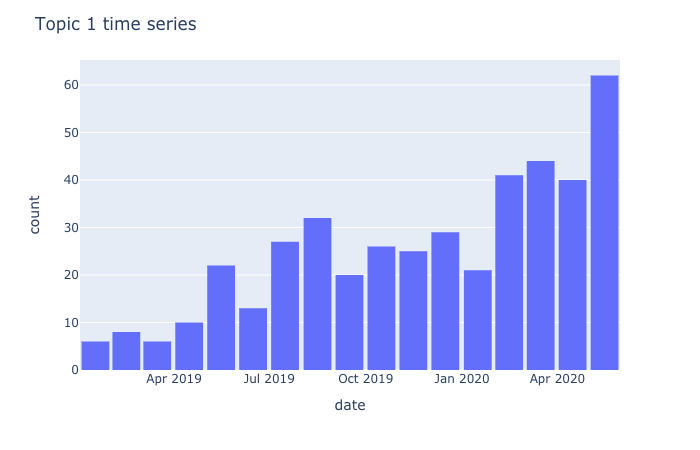

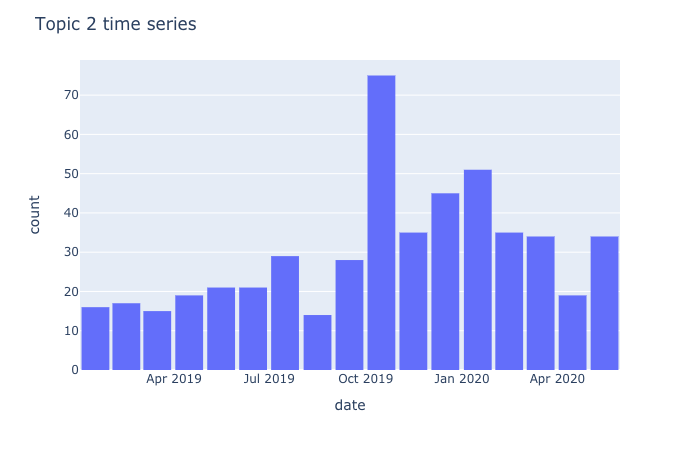

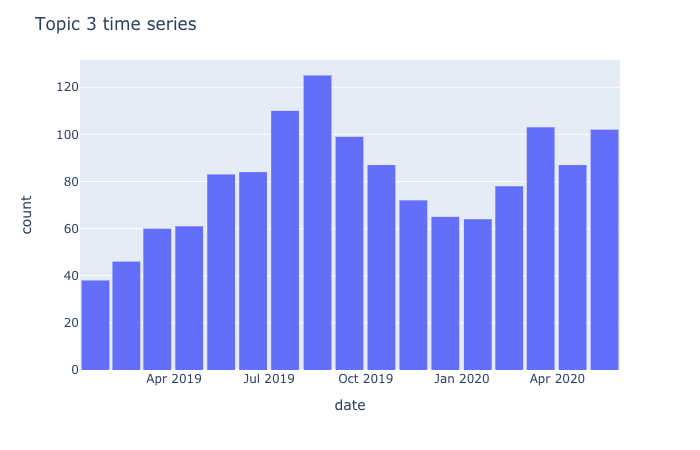

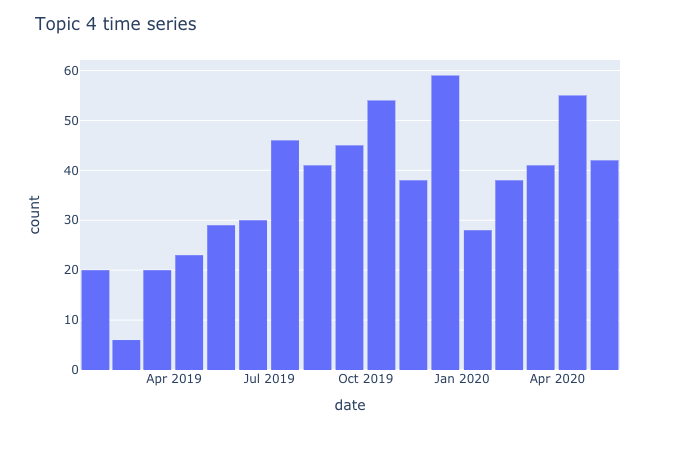

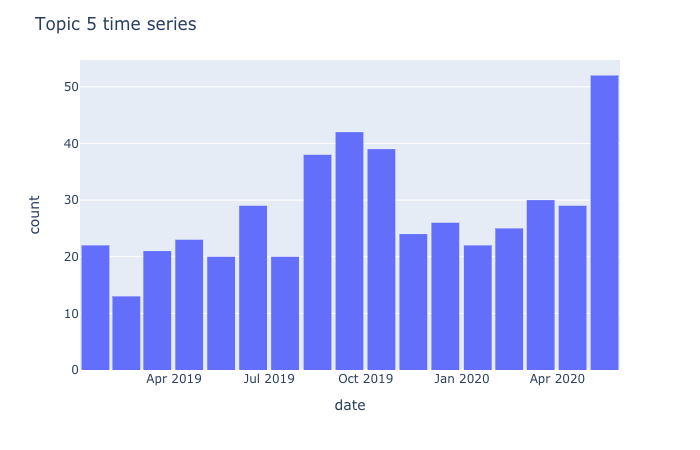

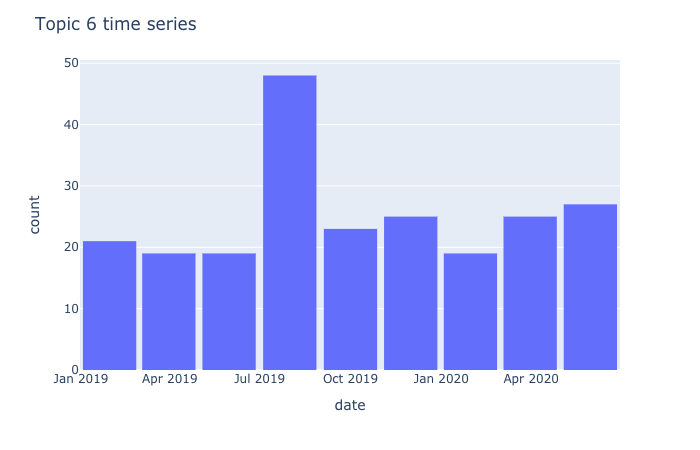

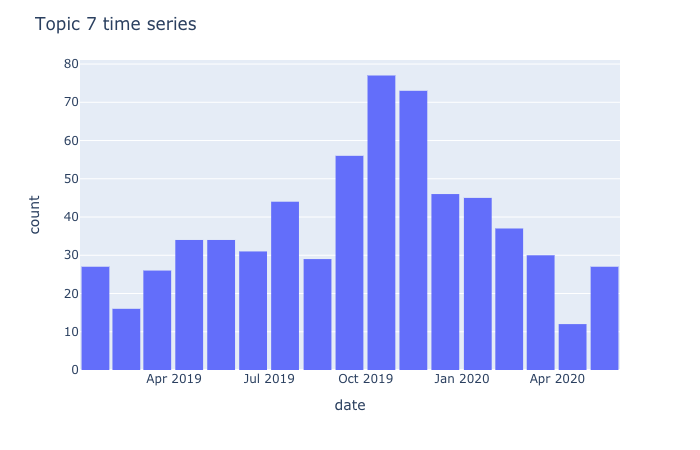

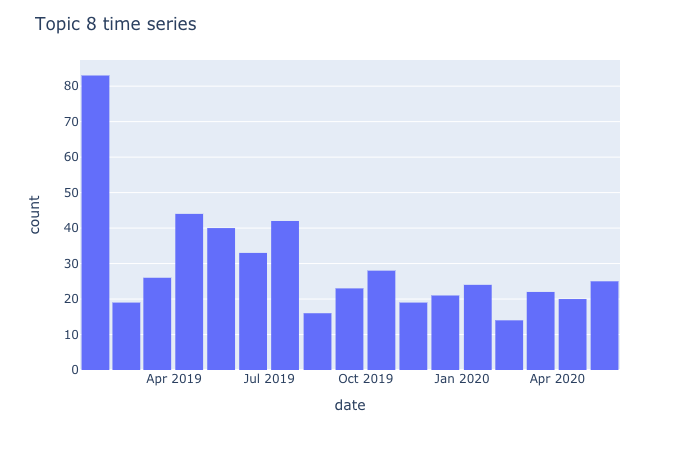

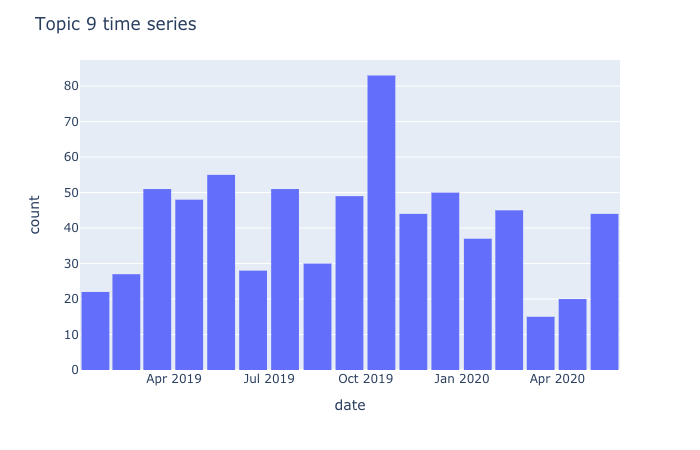

In [41]:
for topic in range(10):
    fig=px.histogram(df[df['topics']==topic],x='date')
    fig.update_layout(title=f'Topic {topic} time series',bargap=0.1)
    fig.show('png')

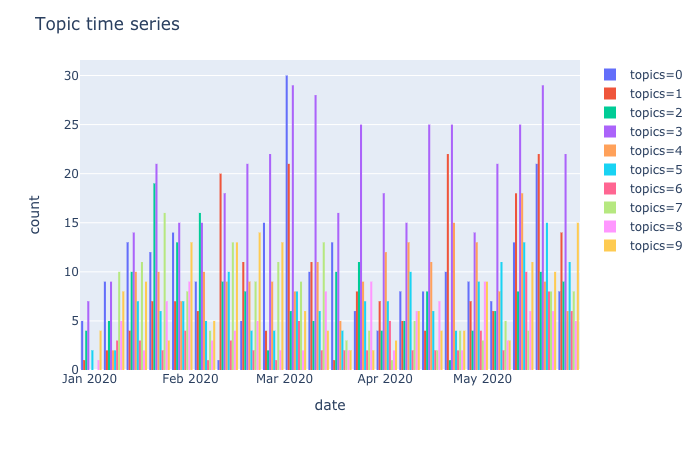

In [42]:
fig=px.histogram(df[df['year']==2020].sort_values('topics'),x='date',color='topics')
fig.update_layout(title=f'Topic time series',bargap=0.1,barmode='group')
fig.show('png')